# Precog Recruitment Task 2

## Object Detection

#### Dependencies (sourced cited at the bottom where required)

In [68]:
import torch
import os
import shutil
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt



In [69]:
img_id=input()
img_path = f"data/img/{img_id}.png"
# Check if the input image exists
if not os.path.exists(img_path):
    print("Input image not found.")
    raise(NameError)


file_dir="curdir"
if os.path.exists(file_dir):
    shutil.rmtree(file_dir)
os.makedirs(file_dir)

# Define the output image path
output_image_path = os.path.join(file_dir, "caption.jpg")
# Copy the input image to the output folder with the specified name
shutil.copy(img_path, output_image_path)



'curdir/caption.jpg'

### Caption Removal (Inpainting) 

In [70]:
import keras_ocr
# helper Function to calculate midpoint of a line
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2) / 2)
    y_mid = int((y1 + y2) / 2)
    return (x_mid, y_mid)


# Initialize keras-ocr pipeline
pipeline = keras_ocr.pipeline.Pipeline()

# Path to the image with text
image_path = 'curdir/caption.jpg'

# Read the image
image = keras_ocr.tools.read(image_path) 

# Recognize text in the image
predictions = pipeline.recognize([image])

# Create a mask for inpainting
mask = np.zeros(image.shape[:2], dtype="uint8")

# Iterate through predicted text regions and create mask
for box in predictions[0]:
    x0, y0 = box[1][0]
    x1, y1 = box[1][1] 
    x2, y2 = box[1][2]
    x3, y3 = box[1][3]
    
    # Calculate midpoints for line drawing
    x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
    x_mid1, y_mid1 = midpoint(x0, y0, x3, y3)
    
    # Calculate thickness based on line length
    thickness = int(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))
    
    # Draw line on mask
    cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mid1), 255, thickness)

# Inpaint the text regions
inpainted_image = cv2.inpaint(image, mask, 7, cv2.INPAINT_NS)


# Save the image without text
cv2.imwrite('curdir/nocaption.jpg', cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))

Looking for /Users/alexthuruthel/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/alexthuruthel/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 1s/step


True

### Text Extraction

The text is extracted from the dataset as it is provided, but text extraction using OCR is implemented in the text_recognition for more general applications.

In [71]:
import jsonlines


file_paths = ['data/train.jsonl', 'data/test.jsonl','data/dev.jsonl'] 

given_text = None
for file_path in file_paths:
        with jsonlines.open(file_path) as reader:
            for obj in reader:
                # print(obj["id"])
                
                if obj["id"] == int(img_id):
                    
                    given_text=obj["text"]

print(given_text)

mussie guy tried to rape me he didn't make it to court


### Object Detection
Yolov8 from the ultralytics module was used as its pretrained model gave the highest accuracy

In [72]:
from ultralytics import YOLO
model = YOLO('yolov8m.pt')

#### Object Detection with Captions

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



image 1/1 /Users/alexthuruthel/sem4/Precog Task/precog_task/curdir/caption.jpg: 640x640 1 person, 242.8ms
Speed: 2.4ms preprocess, 242.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to curdir/captions


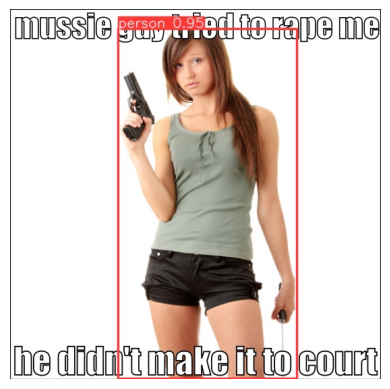

In [73]:
import matplotlib.image as mpimg
import sys



model(source="curdir/caption.jpg", show=False, conf=0.5, save=True,project='curdir', name='captions')

image = mpimg.imread("curdir/captions/caption.jpg")

    # Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

#### Object Detection with caption



image 1/1 /Users/alexthuruthel/sem4/Precog Task/precog_task/curdir/nocaption.jpg: 640x640 1 person, 295.0ms
Speed: 2.1ms preprocess, 295.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to curdir/no_captions


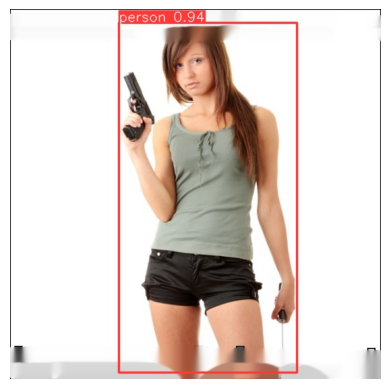

In [74]:
results_noc = model(source="curdir/nocaption.jpg", show=False, conf=0.5, save=True,project='curdir', name='no_captions')

image = mpimg.imread("curdir/no_captions/nocaption.jpg")

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

### Race Detection
using DeepFace module , in paticular the gender and race and emotion detector. The model also supports detection of age and emotion

In [75]:
from deepface import DeepFace

analysis = DeepFace.analyze(img_path, actions = ["gender", "race"],enforce_detection=False)
print(analysis)
prompt_caption_gen=" "
for person in analysis:
    prompt_caption_gen += person["dominant_race"] + " " + person["dominant_gender"] + " "
    
print(prompt_caption_gen)



Action: race: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]  

[{'gender': {'Woman': 99.5016872882843, 'Man': 0.4983194638043642}, 'dominant_gender': 'Woman', 'region': {'x': 236, 'y': 53, 'w': 70, 'h': 70}, 'face_confidence': 8.502199042530265, 'race': {'asian': 7.020376622676849, 'indian': 1.4782820828258991, 'black': 0.1656290260143578, 'white': 55.683302879333496, 'middle eastern': 15.386463701725006, 'latino hispanic': 20.2659472823143}, 'dominant_race': 'white'}]
 white Woman 


### Caption generation

In [76]:

from promptcap import PromptCap

model = PromptCap("tifa-benchmark/promptcap-coco-vqa")  # also support OFA checkpoints. e.g. "OFA-Sys/ofa-large"

image = "curdir/nocaption.jpg"
caption_generated=model.caption(prompt_caption_gen, image)
print(caption_generated)

tifa-benchmark/promptcap-coco-vqa
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPTNeoXTokenizerFast'. 
The class this function is called from is 'OFATokenizer'.


a woman holding a gun


### Sentiment Analysis

In [77]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [78]:

model= SentenceTransformer('bert-base-nli-mean-tokens')

vector=model.encode([given_text,caption_generated])

print(cosine_similarity([vector[0]],vector[1:]))

[[    0.19808]]
